<a href="https://colab.research.google.com/github/BastienBoucherat/geo6149/blob/main/geo6149_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet: Autonomie alimentaire et territoire**
GEO-6149: Géomatique

*   Bastien Boucherat (20155314)
*   Juliette Goulet ()


# **Configuration de l'environnement de travail**

## Arborescence des dossiers
Creation de quelques dossiers de travail sur Google Colab.

In [2]:
# Packages necessary to handle files in Google Colab.
# https://docs.python.org/3/library/os.path.html
import os
import os.path

# This folder is a temporary sandbox
tmp_folder = "/content/tmp"

# If folder does not already exist
if not os.path.exists(tmp_folder):
    # Create it
    os.mkdir(tmp_folder)

# This folder will contain the pre-processed data
# The data is pre-processed to match the study area
data_folder = "/content/data"

# If folder does not already exist
if not os.path.exists(data_folder):
    # Create it
    os.mkdir(data_folder)


## Installation des paquets

Installation de **GeoPandas** pour le traitement des données géospatiales

In [3]:
# Install Geopandas
%%capture
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip install rtree
!ldconfig
!pip install geopandas

Installation de **RasterIO** pour le traitement des données matricielles

In [4]:
# Install rasterIO
%%capture
!pip install rasterio

## Importation des paquets

In [5]:
# Data processing
import numpy as np
import pandas as pd
import geopandas as gpd

In [6]:
# Data processing: raster data
# https://rasterio.readthedocs.io/en/latest/intro.html
import rasterio
import rasterio.plot
import rasterio.mask

In [7]:
# Data format
import json

In [8]:
# Data visualisation
import matplotlib.pyplot as plt
#import contextily as cx # fond de cartes

# **Chargement des données**

## Récuperation des données distantes

In [16]:
# Load remote data sources information
data_sources_df = pd.read_csv('/content/data_sources.csv')

# Download only from selected data sources
data_sources_df = data_sources_df[data_sources_df['Use?']==True]

In [17]:
%%capture

# Remote files will be downloaded and extracted in this folder
# Then, downloaded files will be used to generate pre-processed data files eventually stored locally in another folder
%cd {tmp_folder}

# For selected each source
for idx, data_source in data_sources_df.iterrows():

    # This will point to the useful file to save
    useful_file = ''

    # Get some information from the link
    data_file = data_source['Link'].split('/')[-1]
    data_file_name = data_file.split('.')[0]
    data_file_type = data_file.split('.')[-1] # file extension
    
    # Download source from internet
    if not os.path.exists(data_file):
        source_url = data_source['Link']
        # wget [URL] -P [Directory]
        !wget $source_url
    
    # Extract (if applicable)
    if data_file_type.lower() in ['zip']:

        # Where?
        extract_folder = data_file_name
 
        # Extract
        !unzip -u $data_file -d $extract_folder

        # Save path to file
        useful_file= useful_file + f"{extract_folder}/{data_source['File Name']}"
    else:
        # Save path to file
        useful_file = data_file_name

    # Save the useful files to a persistent folder

    # Shapefile
    if data_source['Format'] == 'shapefile':

        # List of desired file types
        file_types = ['shp','shx','dbf','prj']

        # Target files
        target_file = f"{data_folder}/{data_source['Type']}_{data_source['Area']}"

        # Copy all necessary files
        for file_type in file_types:
            src_file = f'{useful_file}.{file_type}'
            dest_file = f'{target_file}.{file_type}'
            !cp $src_file $dest_file

        # Save the data location
        data_sources_df.at[data_source['index'],'Location'] = f'{target_file}.shp'
    
    # Geotiff
    elif data_source['Format'] == 'geotiff':
        
        # List of desired file types
        file_types = ['tif','tiff']

        # Target files
        target_file = f"{data_folder}/{data_source['Type']}_{data_source['Area']}"
        print(f"Target file: {target_file}")

        # Try for every potentiel type of file
        for file_type in file_types:

            src_file = f'{useful_file}.{file_type}'
            print(f"Target file: {src_file}")
            # Copy every file that is found
            if os.path.exists(src_file):
                dest_file = f'{target_file}.{file_type}'
                dest_file_type = file_type
                !cp $src_file $dest_file
        
        # Save the data location
        data_sources_df.at[data_source['index'],'Location'] = f'{target_file}.{dest_file_type}'

In [14]:
# Remove useless files
if True:
    # Remove extraction folders: files
    command = f'{tmp_folder}/*/*'
    !rm $command
    # Remove extraction folders themselves
    command = f'{tmp_folder}/*'
    !rmdir $command

# Remove downloaded source files
if False:
    # Remove zip files
    command = f'{tmp_folder}/*.zip'
    !rm $command

# Remove useless columns from data source description
data_sources_df = data_sources_df.drop(['Link', 'Use?', 'File Name'], axis='columns')

rmdir: failed to remove '/content/tmp/cb_2018_us_state_500k.zip': Not a directory
rmdir: failed to remove '/content/tmp/GHSL_data_54009_shapefile.zip': Not a directory
rmdir: failed to remove '/content/tmp/lpr_000b16a_e.zip': Not a directory
rmdir: failed to remove '/content/tmp/ppp_2020_1km_Aggregated.tif': Not a directory


## Préparation des données génériques

### Données administratives

**Chargement des frontières administratives** (Etats-Unis)

In [23]:
# Select US boundaries
file_name = data_sources_df[(data_sources_df['Type'] == 'Boundaries') & (data_sources_df['Area'] == 'USA')]['Location'].item()

# Load vector data
us_boundaries_gdf = gpd.read_file(file_name)

# Check projection system
if us_boundaries_gdf.crs == 'None':
    print("Error: CRS information is missing")
else:
    us_boundaries_gdf = us_boundaries_gdf.to_crs('EPSG:4326')

# Cherry-pick and rename information
us_boundaries_gdf['NATION_ID']="USA"
us_boundaries_gdf = us_boundaries_gdf.rename(columns={'STUSPS':'SUB_NATION_ID','NAME':'SUB_NATION_NAME'})
us_boundaries_gdf = us_boundaries_gdf[['NATION_ID', 'SUB_NATION_ID', 'SUB_NATION_NAME', 'geometry']]

,NATION_ID,SUB_NATION_ID,SUB_NATION_NAME,geometry
0,USA,MS,Mississippi,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,USA,NC,North Carolina,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,USA,OK,Oklahoma,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,USA,VA,Virginia,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,USA,WV,West Virginia,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


**Chargement des frontières administratives** (Canada)

In [26]:
# Select Canada boundaries
file_name = data_sources_df[(data_sources_df['Type'] == 'Boundaries') & (data_sources_df['Area'] == 'Canada')]['Location'].item()

# Load vector data
can_boundaries_gdf = gpd.read_file(file_name)

# Check projection system
if can_boundaries_gdf.crs == 'None':
    print("Error: CRS is missing")
else:
    can_boundaries_gdf = can_boundaries_gdf.to_crs('EPSG:4326')

# Cherry-pick and rename information
can_boundaries_gdf['NATION_ID']="CAN"
can_boundaries_gdf = can_boundaries_gdf.rename(columns={'PREABBR':'SUB_NATION_ID','PRENAME':'SUB_NATION_NAME'})
can_boundaries_gdf = can_boundaries_gdf[['NATION_ID', 'SUB_NATION_ID', 'SUB_NATION_NAME', 'geometry']]

,NATION_ID,SUB_NATION_ID,SUB_NATION_NAME,geometry
0,CAN,N.L.,Newfoundland and Labrador,"MULTIPOLYGON (((-57.40258 54.14964, -57.38431 ..."
1,CAN,P.E.I.,Prince Edward Island,"MULTIPOLYGON (((-61.98301 46.45775, -61.98137 ..."
2,CAN,N.S.,Nova Scotia,"MULTIPOLYGON (((-61.90234 45.87878, -61.90057 ..."
3,CAN,N.B.,New Brunswick,"MULTIPOLYGON (((-64.80155 47.80365, -64.80155 ..."
4,CAN,Que.,Quebec,"MULTIPOLYGON (((-58.64702 51.20815, -58.63989 ..."


**Sauvegarde des donnnées administratives** (Canada et Etat-Unis)

In [ ]:
# Merge data for Canada+USA
boundaries_gdf = us_boundaries_gdf.append(can_boundaries_gdf)

# Save as a file
pd.DataFrame(boundaries_gdf).to_csv('/content/data/Boundaries.csv')

<Axes: >

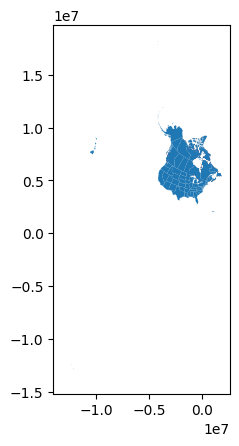

In [29]:
pd.DataFrame(gdf)boundaries_gdf.plot()

## Définition de la zone d'étude

In [ ]:
from shapely.geometry import Polygon, LineString, Point

### Centres urbains

Définition des centres urbains à considérer dans notre analyse.



In [ ]:
# Create a list of the urban centers to include in the study
urban_centers_names = ["Montreal"]

# TODO: use Google maps API to get coordinates from names

# For now, manually provide coordinates
urban_centers_coordinates = [[-73.623983, 45.512047]]

# Create a geometry from the coordinates
urban_centers_geometry = [Point(urban_centers_coordinates[0])]

# Create a python dictionary associating urban centers with their respective geometry
df = {'nom': urban_centers_names, 'geometry': urban_centers_geometry}

# Save information as geodataframe
urban_centers = gpd.GeoDataFrame(df, geometry='geometry')

# Provide the coordinate system
urban_centers.crs = 'EPSG:4326'

Zone d'étude

In [ ]:
file_name = "study_area.geojson"
study_crs = 'EPSG:32188'

# Load the geometry
zone_gdf = gpd.read_file(f'/content/{file_name}')

# Convert to the desired CRS\n",
zone_gdf = zone_gdf.to_crs(study_crs)



## Préparation des données propres à la zone d'étude

Explorer les données

## Données matricielles de densité de population

In [ ]:
# Data file
file_name = 'Population_World.tif'

# Load Data file
population_raster = rasterio.open(f'{data_folder}/{file_name}')

# Show some info about the data
print(population_raster.profile)
print(population_raster.shape) # quelle est la taille de l'image ?
print(population_raster.count) # quel est le nombre de couches ?
print(population_raster.bounds) # quelle est l'enmprise de la couche dans son système de coordonnées ?
print(population_raster.crs) #... d'ailleurs, quel est son système de projection ?
print(population_raster.dtypes) # quel est le type des données des pixels de l'image ?
print(population_raster.width, population_raster.height) # Largeur, hauteur

NameError: ignored

In [ ]:
# rasterio.plot.show(population_raster)

In [ ]:
#
zone_gdf = gpd.read_file('/content/study_area.geojson')

# Create a mask for RasterIO from the study zone
zone_mask = [json.loads(zone_gdf.to_json())['features'][0]['geometry']]

# clip raster
zone_population_raster = rasterio.mask.mask(population_raster, zone_mask, crop=True)

ValueError: ignored

In [ ]:
# Show the data
plt.imshow(zone_population_raster[0][0], cmap='Greys')

NameError: ignored

In [ ]:
# Extract numPY array from raster
img_np = population_raster.read()

# Print some information about the array
print("Dimension de l'array :", img_np.shape)
print("La première bande :", img_np[0]) # pour accéder à la première bande
print("Les valeurs min et max des pixel de la bande :", img_np[0].min(), img_np.max()) # les valeurs minimale et maximale de la bande
print("La valeur du pixel central de la bande :", img_np[0, int(img_np[0].shape[0]/2), int(img_np[0].shape[1]/2)]) # pour accéder à tel ou tel pixel de la bande
print("La moyenne des pixels d'une bande :", np.mean(img_np[0][img_np[0] != 255])) # pour calculer des statistiques classiques sur la première bande
plt.imshow(img_np[0], cmap='Greys') # pour afficher une bande 

#plt.hist(np.histogram(img_np, bins=10, range=None, density=None, weights=None), bins='auto')

In [ ]:
x=len(zone_population_raster[0][0][0])
y=len(zone_population_raster[0][0])
print(f'x={x} y={y}')
print(len(zone_population_raster[0][0][0]))
print("Densite de population au km2 (centre de la carte):", zone_population_raster[0][0][int(y/2)][int(x/2)])

x=463 y=326
463
Densite de population au km2 (centre de la carte): 1475.3801
